In [1]:
pip install catboost

     |████████████████████████████████| 69.2MB 39kB/s 


In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import seaborn as sns
sns.set(color_codes=True)
import matplotlib.pyplot as plt
from math import sqrt
from scipy.stats import norm, skew
from scipy.special import boxcox1p
    
from sklearn.linear_model import ElasticNet, Lasso
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn.feature_selection import RFE
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb

In [2]:
df_2017 = pd.read_csv("/content/drive/MyDrive/oreeva/2017.csv")
df_2018 = pd.read_csv("/content/drive/MyDrive/oreeva/2018.csv")
df_test = pd.read_csv("/content/drive/MyDrive/oreeva/2019.csv")

In [3]:
print(f"df_2017 shape -> {df_2017.shape}")
print(f"df_2018 shape -> {df_2018.shape}")
print(f"df_test shape -> {df_test.shape}")

df_2017 shape -> (992212, 43)
df_2018 shape -> (986565, 43)
df_test shape -> (28323, 42)


In [4]:
def check_df_concat(df1,df2,df_concat):
  if (df1.shape[0] + df2.shape[0]) == df_concat.shape[0]:
    return f"Correctly Joined. Shape : {df_concat.shape}" 
  return "Error"

In [5]:
def missing_values_graph(dataframe):
  plt.figure(figsize=(20,15))
  sns.heatmap(dataframe.isna(),yticklabels=False,cbar=False)


In [6]:
df_train = pd.concat([df_2017,df_2018])
print(df_train.shape)

(1978777, 43)


In [7]:
check_df_concat(df_2017,df_2018,df_train)

'Correctly Joined. Shape : (1978777, 43)'

In [8]:
df_train.describe()

,price,number_of_rooms,total_floor_area,epc_energy_consumption_current,epc_lighting_cost_current,epc_heating_cost_current,epc_hot_water_cost_current,epc_flat_storey_count,epc_number_open_fireplaces,epc_floor_height,latitude,longitude,closeststop,crimesin3km_antisocial,closestschool,closestpark,address_id,distance_center
count,1.978777e+06,850133.000000,960356.000000,960356.000000,960356.000000,960356.000000,960356.000000,85957.000000,853001.000000,525532.000000,1.888177e+06,1.888177e+06,1.866905e+06,1.887698e+06,1.787248e+06,1.746376e+06,1.978777e+06,1.888177e+06
mean,3.441981e+05,4.564547,90.015271,982.718065,78.930790,701.405613,140.895424,3.168922,0.200909,2.453044,5.235284e+01,-1.365917e+00,3.112370e+02,2.356189e+03,4.835813e+02,9.640953e+02,9.855989e+07,6.190759e+00
std,1.942431e+06,1.730543,52.947399,4775.125172,40.838095,540.060623,75.444502,2.482652,0.572482,0.605628,1.144130e+00,1.327566e+00,4.756355e+02,2.905756e+03,4.318005e+02,7.925460e+02,5.385521e+06,7.257374e+00
min,1.000000e+00,1.000000,0.000000,-1323.000000,-8.000000,-801.000000,-31.000000,0.000000,0.000000,0.000000,4.991321e+01,-6.352647e+00,5.321700e-01,0.000000e+00,0.000000e+00,3.000000e+00,8.857593e+07,3.301802e-03
25%,1.440000e+05,3.000000,64.000000,196.000000,54.000000,394.000000,95.000000,2.000000,0.000000,2.330000,5.145793e+01,-2.247356e+00,9.674732e+01,4.490000e+02,2.420000e+02,4.120000e+02,9.381703e+07,1.796913e+00
50%,2.265000e+05,4.000000,81.000000,262.000000,72.000000,594.000000,116.000000,3.000000,0.000000,2.400000,5.219065e+01,-1.402552e+00,1.605978e+02,1.433000e+03,3.820000e+02,7.120000e+02,9.918091e+07,3.754652e+00
75%,3.520000e+05,5.000000,104.000000,349.000000,95.000000,852.000000,161.000000,4.000000,0.000000,2.510000,5.337324e+01,-2.731810e-01,2.938576e+02,3.040000e+03,5.740000e+02,1.241000e+03,1.036150e+08,7.704068e+00
max,7.075042e+08,91.000000,5327.890000,416354.000000,6760.000000,62707.000000,1411.000000,63.000000,75.000000,230.000000,5.579742e+01,1.758397e+00,4.815169e+03,2.307400e+04,4.743000e+03,4.838000e+03,1.056136e+08,8.374496e+01


In [9]:
df_train.columns

Index(['transaction_id', 'created', 'duration', 'price', 'old_new',
       'ppd_category', 'property_type', 'flat', 'floor_level',
       'number_of_rooms', 'total_floor_area', 'epc_current_energy_rating',
       'epc_potential_energy_rating', 'epc_property_type', 'epc_built_form',
       'epc_energy_consumption_current', 'epc_lighting_cost_current',
       'epc_heating_cost_current', 'epc_hot_water_cost_current',
       'epc_flat_storey_count', 'epc_glazed_area',
       'epc_number_open_fireplaces', 'epc_windows_description',
       'epc_windows_energy_eff', 'epc_walls_description',
       'epc_walls_energy_eff', 'epc_roof_description', 'epc_roof_energy_eff',
       'epc_floor_height', 'postcode', 'city', 'street', 'building_name',
       'building_number', 'latitude', 'longitude', 'postcode_sector',
       'closeststop', 'crimesin3km_antisocial', 'closestschool', 'closestpark',
       'address_id', 'distance_center'],
      dtype='object')

Target Variable: 'price' -> seems to have some outliers, futher analysis needed. 
Features: Some features have quite unusual values.(Epc features) 

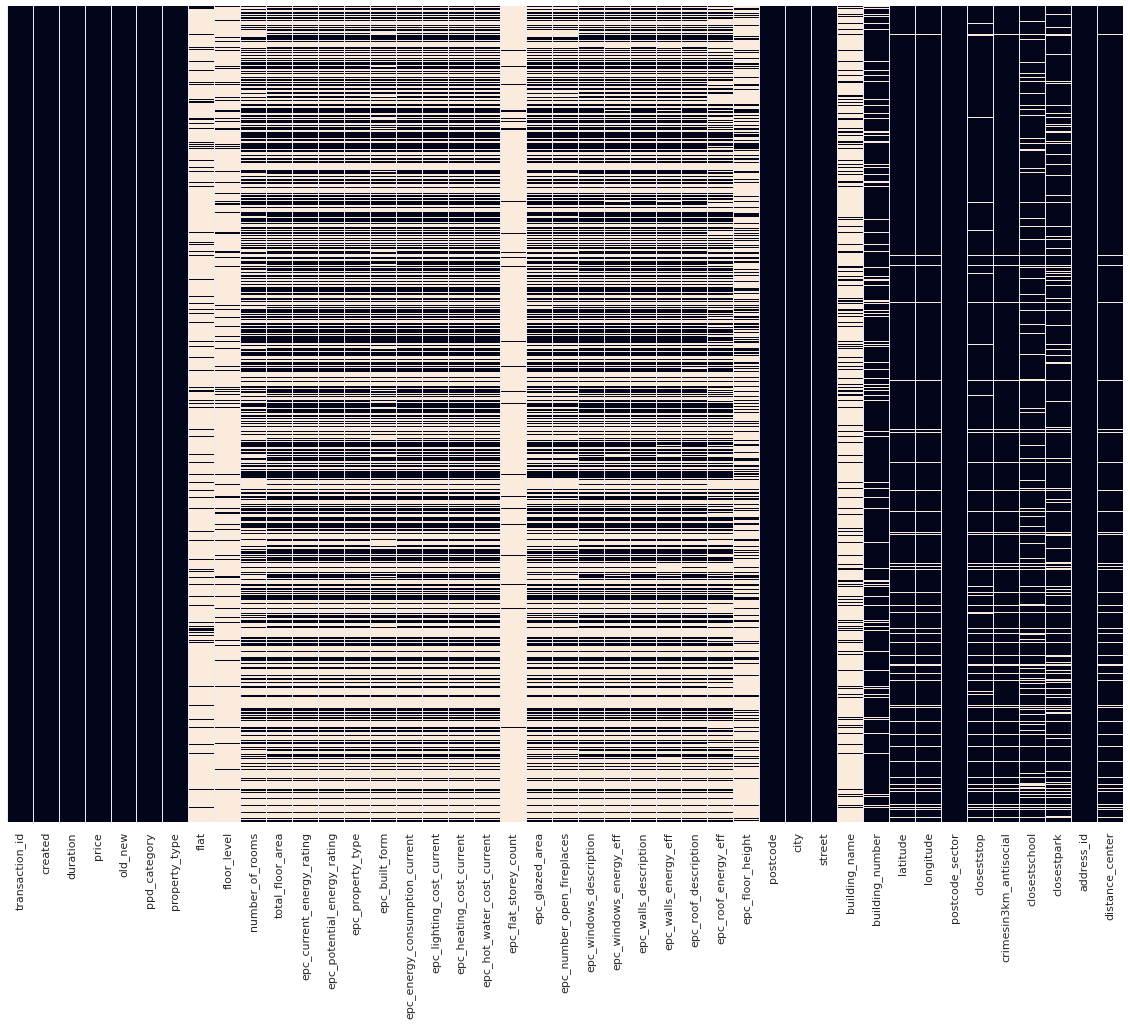

In [10]:
missing_values_graph(df_train)

In [11]:
df_train.corr()['price'].sort_values(ascending=False)

price                             1.000000
total_floor_area                  0.118270
epc_lighting_cost_current         0.093115
number_of_rooms                   0.085685
epc_heating_cost_current          0.077295
crimesin3km_antisocial            0.075663
epc_flat_storey_count             0.065098
epc_number_open_fireplaces        0.046245
longitude                         0.042186
address_id                        0.026956
epc_floor_height                  0.021534
epc_hot_water_cost_current        0.019407
closestschool                     0.013722
epc_energy_consumption_current    0.009113
closeststop                      -0.001349
closestpark                      -0.007773
distance_center                  -0.016440
latitude                         -0.049843
Name: price, dtype: float64

Factors affect the price of house: 
  * Historical Price - Sale Price of property
  * Location - location of property
  * Neighborhood - **school** ,crime rate [Ref](https://www.inman.com/2017/08/07/6-factors-that-influence-a-homes-value/#:~:text=Research%20isn%E2%80%99t%20clear%20whether%20home%20prices%20influence%20school%20system%20investment%2C%20or%20whether%20quality%20schools%20influence%20home%20prices%2C%20but%20either%20way%2C%20school%20quality%20significantly%20affects%20home%20values.)
  * Size and type - property size, type of property. 
  * Age - Old/New 
  * Neaby Features - shopping center, distance from center, bus stops, parks etc.

In [12]:
features = ['price','total_floor_area','epc_lighting_cost_current','number_of_rooms',
            'epc_heating_cost_current','crimesin3km_antisocial','epc_flat_storey_count',
            'epc_number_open_fireplaces','longitude','address_id','epc_floor_height',
            'epc_hot_water_cost_current','closestschool','epc_energy_consumption_current',
            'closeststop','closestpark','distance_center','latitude','old_new','duration',
            'property_type']

In [13]:
train_data = df_train[features]

In [14]:
train_data.head()

,price,total_floor_area,epc_lighting_cost_current,number_of_rooms,epc_heating_cost_current,crimesin3km_antisocial,epc_flat_storey_count,epc_number_open_fireplaces,longitude,address_id,epc_floor_height,epc_hot_water_cost_current,closestschool,epc_energy_consumption_current,closeststop,closestpark,distance_center,latitude,old_new,duration,property_type
0,86787,NaN,NaN,NaN,NaN,741.0,NaN,NaN,-1.191828,102877980,NaN,NaN,735.0,NaN,130.419369,674.0,3.658300,53.177751,Y,F,T
1,805000,173.04,189.0,9.0,1489.0,10.0,NaN,0.0,-1.605473,97804281,2.7,259.0,633.0,297.0,446.805795,NaN,27.205352,51.380891,N,F,D
2,275000,NaN,NaN,NaN,NaN,1576.0,NaN,NaN,-2.134401,101429204,NaN,NaN,845.0,NaN,310.743404,745.0,5.659612,52.469943,N,F,D
3,220000,NaN,NaN,NaN,NaN,184.0,NaN,NaN,-1.762286,100150188,NaN,NaN,817.0,NaN,265.388640,686.0,4.190032,52.377534,N,L,T
4,237000,105.00,67.0,NaN,320.0,643.0,NaN,NaN,-1.376669,93361793,NaN,87.0,582.0,95.0,236.354546,761.0,14.267637,52.531956,N,F,D


In [15]:
df_train_missing_data = pd.DataFrame(train_data.isna().sum().sort_values(ascending=False), columns=['#Missing_Values'])
df_train_missing_data = df_train_missing_data[df_train_missing_data['#Missing_Values'] > 0]
df_train_missing_data

,#Missing_Values
epc_flat_storey_count,1892820
epc_floor_height,1453245
number_of_rooms,1128644
epc_number_open_fireplaces,1125776
epc_heating_cost_current,1018421
total_floor_area,1018421
epc_energy_consumption_current,1018421
epc_hot_water_cost_current,1018421
epc_lighting_cost_current,1018421
closestpark,232401


* Dropping the features epc_flat_storey_count(>95%) and epc_floor_height(>72%) contains nan entries.


In [16]:
train_data = train_data.drop(['epc_flat_storey_count','epc_floor_height'],axis=1)
train_data.shape

(1978777, 19)

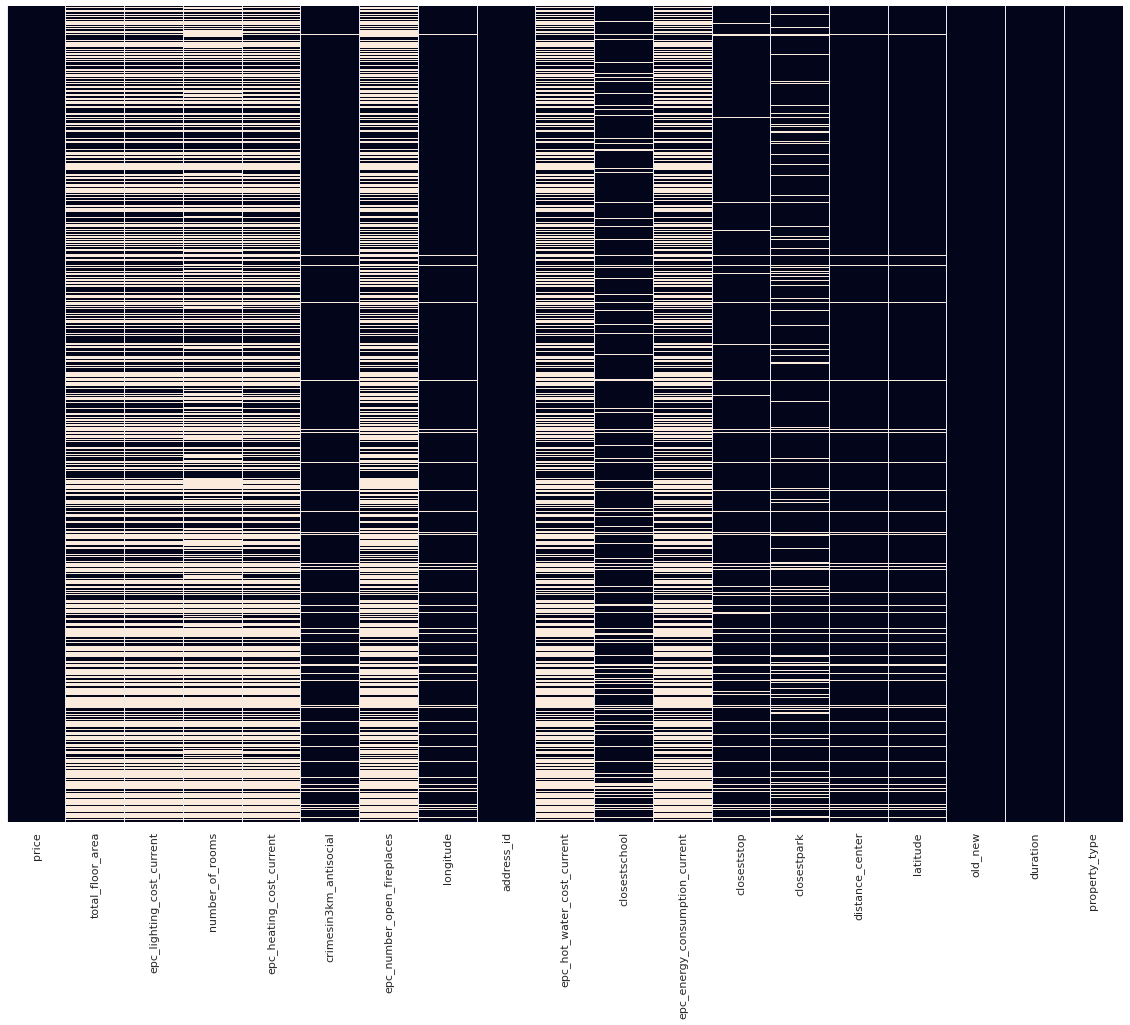

In [17]:
missing_values_graph(train_data)


* From the property_type we might be able to guess the missing values in total_floor_area and epc features, because of the different property types.

In [18]:
train_data.property_type.value_counts()

T    541990
S    521002
D    455989
F    345601
O    114195
Name: property_type, dtype: int64

- F=flat T=terraced house D=detached house and S=semidetached house O= others

In [19]:
#Seperate numerical and categorical data
numerical = []
categorical = []
for i in train_data.columns:
  if train_data[i].dtype == "object":
    categorical.append(i)
  else: 
    numerical.append(i)

In [20]:
print("Numerical: ",numerical)
print("Categorical: ",categorical)


Numerical:  ['price', 'total_floor_area', 'epc_lighting_cost_current', 'number_of_rooms', 'epc_heating_cost_current', 'crimesin3km_antisocial', 'epc_number_open_fireplaces', 'longitude', 'address_id', 'epc_hot_water_cost_current', 'closestschool', 'epc_energy_consumption_current', 'closeststop', 'closestpark', 'distance_center', 'latitude']
Categorical:  ['old_new', 'duration', 'property_type']


###TOTAL_FLOOR_AREA

In [21]:
print("Median of total_floor_area(property_type=F)",np.median(train_data.total_floor_area[train_data.property_type == 'F'].dropna()))
print("Median of total_floor_area(property_type=T)",np.median(train_data.total_floor_area[train_data.property_type == 'T'].dropna()))
print("Median of total_floor_area(property_type=D)",np.median(train_data.total_floor_area[train_data.property_type == 'D'].dropna()))
print("Median of total_floor_area(property_type=S)",np.median(train_data.total_floor_area[train_data.property_type == 'S'].dropna()))
print("Median of total_floor_area(property_type=O)",np.median(train_data.total_floor_area[train_data.property_type == 'O'].dropna()))

Median of total_floor_area(property_type=F) 58.0
Median of total_floor_area(property_type=T) 79.0
Median of total_floor_area(property_type=D) 113.0
Median of total_floor_area(property_type=S) 83.34
Median of total_floor_area(property_type=O) 90.66


In [22]:
#Fill total_floor_area
train_data.total_floor_area[train_data.property_type == 'F'] = train_data.total_floor_area[train_data.property_type == 'F'].fillna(58.0)
train_data.total_floor_area[train_data.property_type == 'T'] = train_data.total_floor_area[train_data.property_type == 'T'].fillna(79.0)
train_data.total_floor_area[train_data.property_type == 'D'] = train_data.total_floor_area[train_data.property_type == 'D'].fillna(113.0)
train_data.total_floor_area[train_data.property_type == 'S'] = train_data.total_floor_area[train_data.property_type == 'S'].fillna(83.34)
train_data.total_floor_area[train_data.property_type == 'O'] = train_data.total_floor_area[train_data.property_type == 'O'].fillna(90.66)

Max 5327.89
Min 0.0


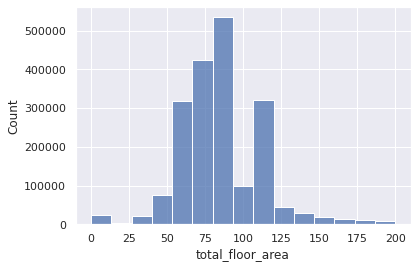

In [23]:
print("Max",max(train_data.total_floor_area))
print("Min",min(train_data.total_floor_area))
sns.histplot(train_data.total_floor_area[train_data.total_floor_area < 200],bins=15)

  * Floor Area [Ref](https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/725085/Floor_Space_in_English_Homes_main_report.pdf)
  * Average House Size: [Ref](https://https://www.dwh.co.uk/library/Average-UK-house-sizes/) (Convert sq.ft to m^2)

In [24]:
train_data.total_floor_area.isna().sum()

0

###NUMBER_OF_ROOMS

In [25]:
print("Median of number_of_rooms(property_type=F)",np.median(train_data.number_of_rooms[train_data.property_type == 'F'].dropna()))
print("Median of number_of_rooms(property_type=T)",np.median(train_data.number_of_rooms[train_data.property_type == 'T'].dropna()))
print("Median of number_of_rooms(property_type=D)",np.median(train_data.number_of_rooms[train_data.property_type == 'D'].dropna()))
print("Median of number_of_rooms(property_type=S)",np.median(train_data.number_of_rooms[train_data.property_type == 'S'].dropna()))
print("Median of number_of_rooms(property_type=O)",np.median(train_data.number_of_rooms[train_data.property_type == 'O'].dropna()))

Median of number_of_rooms(property_type=F) 3.0
Median of number_of_rooms(property_type=T) 4.0
Median of number_of_rooms(property_type=D) 6.0
Median of number_of_rooms(property_type=S) 5.0
Median of number_of_rooms(property_type=O) 5.0


In [26]:
train_data.number_of_rooms[train_data.property_type == 'F'] = train_data.number_of_rooms[train_data.property_type == 'F'].fillna(3)
train_data.number_of_rooms[train_data.property_type == 'T'] = train_data.number_of_rooms[train_data.property_type == 'T'].fillna(4)
train_data.number_of_rooms[train_data.property_type == 'D'] = train_data.number_of_rooms[train_data.property_type == 'D'].fillna(6)
train_data.number_of_rooms[train_data.property_type == 'S'] = train_data.number_of_rooms[train_data.property_type == 'S'].fillna(5)
train_data.number_of_rooms[train_data.property_type == 'O'] = train_data.number_of_rooms[train_data.property_type == 'O'].fillna(5)

Max 91.0
Min 1.0


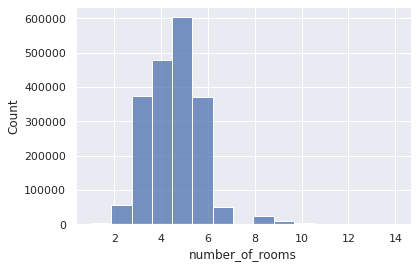

In [27]:
print("Max",max(train_data.number_of_rooms))
print("Min",min(train_data.number_of_rooms))
sns.histplot(train_data.number_of_rooms[train_data.number_of_rooms < 15],bins=15)

###EPC

*   Epc_energy_consumption_current = estimated total energy consumption for the property in a 12 month period (kWh/m2).
*   Epc_heating_cost_current'= GBP. Current estimated annual energy costs for heating the property
* Epc_lighting_cost_current' = GBP. Current  estimated annual energy costs for lighting the property.
* Epc_number_open_fireplaces = The number of Open Fireplaces in the Property. An Open Fireplace is a fireplace that still allows air to pass between the inside of the Property and the outside.
* Epc_flat_storey_count = The number of storeys in the apartment block.
* Epc_floor_height = Average height of the storey in metres.
* Epc_hot_water_cost_current = GBP. Current estimated annual energy costs for hot water










In [28]:
#Investigating epc features
# ['epc_energy_consumption_current','epc_lighting_cost_current','epc_heating_cost_current'
# 	,'epc_hot_water_cost_current','epc_number_open_fireplaces']


In [30]:
def data_by_property_type(df,col_name):
  print("Median of col_name (property_type=F)",np.median(df[col_name][df.property_type == 'F'].dropna()))
  print("Median of col_name (property_type=T)",np.median(df[col_name][df.property_type == 'T'].dropna()))
  print("Median of col_name (property_type=D)",np.median(df[col_name][df.property_type == 'D'].dropna()))
  print("Median of col_name (property_type=S)",np.median(df[col_name][df.property_type == 'S'].dropna()))
  print("Median of col_name (property_type=O)",np.median(df[col_name][df.property_type == 'O'].dropna()))

In [31]:
data_by_property_type(train_data,'epc_number_open_fireplaces')

Median of col_name (property_type=F) 0.0
Median of col_name (property_type=T) 0.0
Median of col_name (property_type=D) 0.0
Median of col_name (property_type=S) 0.0
Median of col_name (property_type=O) 0.0


In [32]:
train_data.epc_number_open_fireplaces = train_data.epc_number_open_fireplaces.fillna(0)

In [33]:
data_by_property_type(train_data,'epc_heating_cost_current')

Median of col_name (property_type=F) 300.0
Median of col_name (property_type=T) 598.0
Median of col_name (property_type=D) 770.0
Median of col_name (property_type=S) 646.0
Median of col_name (property_type=O) 787.0


In [34]:
train_data.epc_heating_cost_current[train_data.property_type == 'F'] = train_data.epc_heating_cost_current[train_data.property_type == 'F'].fillna(300)
train_data.epc_heating_cost_current[train_data.property_type == 'T'] = train_data.epc_heating_cost_current[train_data.property_type == 'T'].fillna(598)
train_data.epc_heating_cost_current[train_data.property_type == 'D'] = train_data.epc_heating_cost_current[train_data.property_type == 'D'].fillna(770)
train_data.epc_heating_cost_current[train_data.property_type == 'S'] = train_data.epc_heating_cost_current[train_data.property_type == 'S'].fillna(646)
train_data.epc_heating_cost_current[train_data.property_type == 'O'] = train_data.epc_heating_cost_current[train_data.property_type == 'O'].fillna(787)

In [35]:
data_by_property_type(train_data,'epc_lighting_cost_current')

Median of col_name (property_type=F) 53.0
Median of col_name (property_type=T) 69.0
Median of col_name (property_type=D) 96.0
Median of col_name (property_type=S) 74.0
Median of col_name (property_type=O) 81.0


In [36]:
train_data.epc_lighting_cost_current[train_data.property_type == 'F'] = train_data.epc_lighting_cost_current[train_data.property_type == 'F'].fillna(53.0)
train_data.epc_lighting_cost_current[train_data.property_type == 'T'] = train_data.epc_lighting_cost_current[train_data.property_type == 'T'].fillna(69.0)
train_data.epc_lighting_cost_current[train_data.property_type == 'D'] = train_data.epc_lighting_cost_current[train_data.property_type == 'D'].fillna(96.0)
train_data.epc_lighting_cost_current[train_data.property_type == 'S'] = train_data.epc_lighting_cost_current[train_data.property_type == 'S'].fillna(74.0)
train_data.epc_lighting_cost_current[train_data.property_type == 'O'] = train_data.epc_lighting_cost_current[train_data.property_type == 'O'].fillna(81.0)

In [37]:
data_by_property_type(train_data,'epc_hot_water_cost_current')

Median of col_name (property_type=F) 106.0
Median of col_name (property_type=T) 110.0
Median of col_name (property_type=D) 140.0
Median of col_name (property_type=S) 115.0
Median of col_name (property_type=O) 138.0


In [38]:
train_data.epc_hot_water_cost_current[train_data.property_type == 'F'] = train_data.epc_hot_water_cost_current[train_data.property_type == 'F'].fillna(106.0)
train_data.epc_hot_water_cost_current[train_data.property_type == 'T'] = train_data.epc_hot_water_cost_current[train_data.property_type == 'T'].fillna(110.0)
train_data.epc_hot_water_cost_current[train_data.property_type == 'D'] = train_data.epc_hot_water_cost_current[train_data.property_type == 'D'].fillna(140.0)
train_data.epc_hot_water_cost_current[train_data.property_type == 'S'] = train_data.epc_hot_water_cost_current[train_data.property_type == 'S'].fillna(115.0)
train_data.epc_hot_water_cost_current[train_data.property_type == 'O'] = train_data.epc_hot_water_cost_current[train_data.property_type == 'O'].fillna(138.0)

In [39]:
data_by_property_type(train_data,'epc_energy_consumption_current')

Median of col_name (property_type=F) 236.0
Median of col_name (property_type=T) 276.0
Median of col_name (property_type=D) 242.0
Median of col_name (property_type=S) 274.0
Median of col_name (property_type=O) 284.0


In [40]:
train_data.epc_energy_consumption_current[train_data.property_type == 'F'] = train_data.epc_energy_consumption_current[train_data.property_type == 'F'].fillna(236.0)
train_data.epc_energy_consumption_current[train_data.property_type == 'T'] = train_data.epc_energy_consumption_current[train_data.property_type == 'T'].fillna(276.0)
train_data.epc_energy_consumption_current[train_data.property_type == 'D'] = train_data.epc_energy_consumption_current[train_data.property_type == 'D'].fillna(242.0)
train_data.epc_energy_consumption_current[train_data.property_type == 'S'] = train_data.epc_energy_consumption_current[train_data.property_type == 'S'].fillna(274.0)
train_data.epc_energy_consumption_current[train_data.property_type == 'O'] = train_data.epc_energy_consumption_current[train_data.property_type == 'O'].fillna(284.0)

In [41]:
train_data.isna().sum().sort_values(ascending=False)

closestpark                       232401
closestschool                     191529
closeststop                       111872
crimesin3km_antisocial             91079
latitude                           90600
distance_center                    90600
longitude                          90600
property_type                          0
total_floor_area                       0
epc_lighting_cost_current              0
number_of_rooms                        0
epc_heating_cost_current               0
epc_hot_water_cost_current             0
epc_number_open_fireplaces             0
address_id                             0
duration                               0
epc_energy_consumption_current         0
old_new                                0
price                                  0
dtype: int64

In [42]:
train_data = train_data.dropna()

In [43]:
train_data.shape

(1658980, 19)

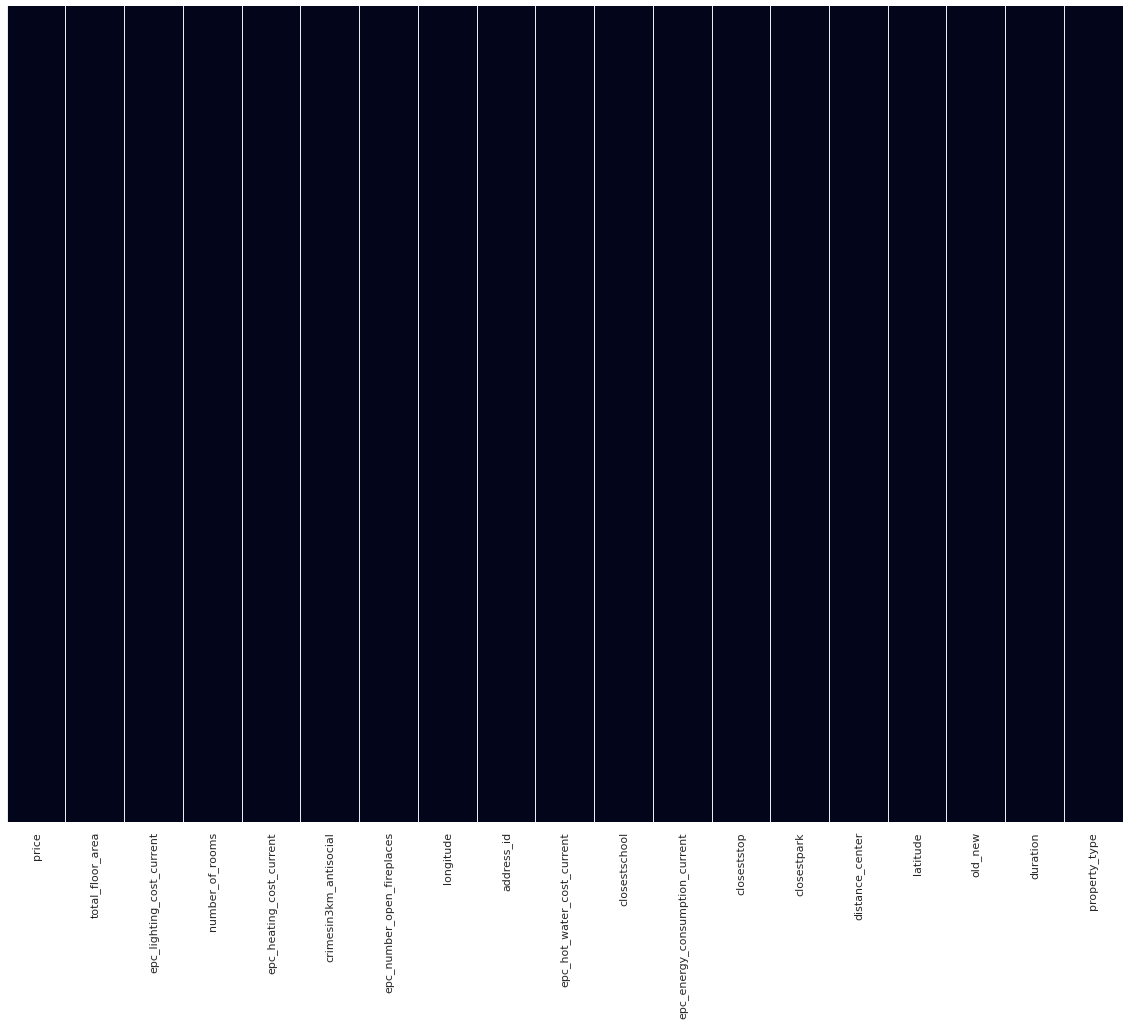

In [44]:
missing_values_graph(train_data)

In [48]:
d_cols = ['old_new','duration','property_type']
dummies = pd.get_dummies(train_data[d_cols])
dummies

,old_new_N,old_new_Y,duration_F,duration_L,property_type_D,property_type_F,property_type_O,property_type_S,property_type_T
0,0,1,1,0,0,0,0,0,1
2,1,0,1,0,1,0,0,0,0
3,1,0,0,1,0,0,0,0,1
4,1,0,1,0,1,0,0,0,0
5,1,0,1,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...
986559,1,0,1,0,0,0,0,0,1
986560,1,0,0,1,0,0,0,0,1
986562,1,0,1,0,1,0,0,0,0
986563,1,0,0,1,0,1,0,0,0


In [49]:
df_train_final = pd.concat([train_data,dummies],axis=1)
df_train_final.head()

,price,total_floor_area,epc_lighting_cost_current,number_of_rooms,epc_heating_cost_current,crimesin3km_antisocial,epc_number_open_fireplaces,longitude,address_id,epc_hot_water_cost_current,closestschool,epc_energy_consumption_current,closeststop,closestpark,distance_center,latitude,old_new,duration,property_type,old_new_N,old_new_Y,duration_F,duration_L,property_type_D,property_type_F,property_type_O,property_type_S,property_type_T
0,86787,79.0,69.0,4.0,598.0,741.0,0.0,-1.191828,102877980,110.0,735.0,276.0,130.419369,674.0,3.658300,53.177751,Y,F,T,0,1,1,0,0,0,0,0,1
2,275000,113.0,96.0,6.0,770.0,1576.0,0.0,-2.134401,101429204,140.0,845.0,242.0,310.743404,745.0,5.659612,52.469943,N,F,D,1,0,1,0,1,0,0,0,0
3,220000,79.0,69.0,4.0,598.0,184.0,0.0,-1.762286,100150188,110.0,817.0,276.0,265.388640,686.0,4.190032,52.377534,N,L,T,1,0,0,1,0,0,0,0,1
4,237000,105.0,67.0,6.0,320.0,643.0,0.0,-1.376669,93361793,87.0,582.0,95.0,236.354546,761.0,14.267637,52.531956,N,F,D,1,0,1,0,1,0,0,0,0
5,165000,113.0,96.0,6.0,770.0,2026.0,0.0,-1.162210,102871567,140.0,128.0,242.0,90.906013,619.0,2.442769,53.138263,N,F,D,1,0,1,0,1,0,0,0,0


In [ ]:
df_train_final = df_train_final.drop(d_cols,axis=1)


In [52]:
print("Shape: ",df_train_final.shape)
df_train_final.head()

Shape:  (1658980, 25)


,price,total_floor_area,epc_lighting_cost_current,number_of_rooms,epc_heating_cost_current,crimesin3km_antisocial,epc_number_open_fireplaces,longitude,address_id,epc_hot_water_cost_current,closestschool,epc_energy_consumption_current,closeststop,closestpark,distance_center,latitude,old_new_N,old_new_Y,duration_F,duration_L,property_type_D,property_type_F,property_type_O,property_type_S,property_type_T
0,86787,79.0,69.0,4.0,598.0,741.0,0.0,-1.191828,102877980,110.0,735.0,276.0,130.419369,674.0,3.658300,53.177751,0,1,1,0,0,0,0,0,1
2,275000,113.0,96.0,6.0,770.0,1576.0,0.0,-2.134401,101429204,140.0,845.0,242.0,310.743404,745.0,5.659612,52.469943,1,0,1,0,1,0,0,0,0
3,220000,79.0,69.0,4.0,598.0,184.0,0.0,-1.762286,100150188,110.0,817.0,276.0,265.388640,686.0,4.190032,52.377534,1,0,0,1,0,0,0,0,1
4,237000,105.0,67.0,6.0,320.0,643.0,0.0,-1.376669,93361793,87.0,582.0,95.0,236.354546,761.0,14.267637,52.531956,1,0,1,0,1,0,0,0,0
5,165000,113.0,96.0,6.0,770.0,2026.0,0.0,-1.162210,102871567,140.0,128.0,242.0,90.906013,619.0,2.442769,53.138263,1,0,1,0,1,0,0,0,0


In [53]:
clean_train_data = df_train_final.to_csv("/content/clean_train_data.csv")

In [56]:
X = df_train_final.drop('price',axis=1)
y = df_train_final['price']

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size= 0.25, 
                                                    random_state=1234)


#MODELS

In [72]:
from catboost import CatBoostRegressor


In [73]:
model = CatBoostRegressor(learning_rate=0.14, depth=8, loss_function="MAE",
                          iterations=3200, silent=True)
model.fit(
   X_train, y_train,
    plot=True
)

preds = model.predict(X_test)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [82]:
print("MdAPE:", np.median(abs(preds - y_test) / preds))

MdAPE: 0.13939773829450514


In [86]:
model.get_feature_importance(prettified=True)

,Feature Id,Importances
0,crimesin3km_antisocial,20.586746
1,closestpark,18.258522
2,epc_heating_cost_current,15.593295
3,longitude,12.739039
4,property_type_O,8.332565
5,property_type_F,8.237089
6,latitude,4.252117
7,address_id,3.767017
8,closeststop,3.091782
9,distance_center,2.439508


In [60]:
import lightgbm as lgb

model1 = lgb.LGBMRegressor(objective='regression',num_leaves=8,
                           learning_rate=0.1, n_estimators=720,
                              max_bin = 100, bagging_fraction = 0.5,
                              bagging_freq = 10, feature_fraction = 0.2319,
                              feature_fraction_seed=10, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 10)

In [61]:
model1.fit(X_train,y_train)


LGBMRegressor(bagging_fraction=0.5, bagging_freq=10, bagging_seed=9,
              boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              feature_fraction=0.2319, feature_fraction_seed=10,
              importance_type='split', learning_rate=0.1, max_bin=100,
              max_depth=-1, min_child_samples=20, min_child_weight=0.001,
              min_data_in_leaf=6, min_split_gain=0.0,
              min_sum_hessian_in_leaf=10, n_estimators=720, n_jobs=-1,
              num_leaves=8, objective='regression', random_state=None,
              reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
              subsample_for_bin=200000, subsample_freq=0)

In [64]:
lgb_pred = model1.predict(X_test)
print("MdAPE: Enet", np.median(abs(lgb_pred - y_test) / lgb_pred))

MdAPE: Enet 0.258855731076019
